In [0]:
import tensorflow as tf
import gym
from tensorflow.keras.layers import Dense,Conv2D,Flatten
import skimage
from skimage import transform 
from skimage.color import rgb2gray
import numpy as np
from tensorflow.keras import Model

In [0]:
tf.__version__
#!pip install tensorflow-gpu=="2.0.0"

'2.0.0'

In [0]:
env_name = "MsPacman-v0"
env = gym.make(env_name)

In [0]:
env.observation_space

Box(210, 160, 3)

In [0]:
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())

In [0]:
env.action_space

Discrete(9)

In [0]:
env.reset()

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[228, 111, 111],
        [228, 111, 111],
        [228, 111, 111],
        ...,
        [228, 111, 111],
        [228, 111, 111],
        [228, 111, 111]],

       [[228, 111, 111],
        [228, 111, 111],
        [228, 111, 111],
        ...,
        [228, 111, 111],
        [228, 111, 111],
        [228, 111, 111]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

(210, 160, 3)
(180, 160, 3)
(170, 170)


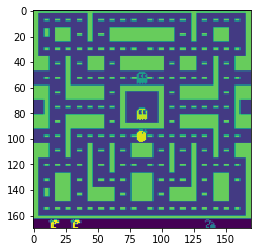

In [0]:
obs,reward,done,_ = env.step(1)
print(obs.shape)
import matplotlib.pyplot as plt
print(obs[:][:180].shape)
obs = obs[:][:180]
obs= rgb2gray(obs)
obs = transform.resize(obs,[170,170])
print(obs.shape)
plt.imshow(obs)

In [0]:
def data_preprocess_image(image):
  image = rgb2gray(image)
  image = image[:][:180]
  image = transform.resize(image,[170,170])
  return image

In [0]:
from collections import deque


In [0]:
stack_size = 4 
stack_frames = deque([np.zeros((170,170),dtype=np.int) for i in range(stack_size)],maxlen=4)
def stack_frames(stack_frames,state,is_new_episode):
  frame = data_preprocess_image(state)
  if is_new_episode:
    stack_frames = deque([np.zeros((170,170),dtype=np.int) for i in range(stack_size)],maxlen=4)
    stack_frames.append(frame)
    stack_frames.append(frame)
    stack_frames.append(frame)
    stack_frames.append(frame)  
    stacked_state = np.stack(stack_frames,axis=2)
  else:
    stack_frames.append(frame)
    stacked_state = np.stack(stack_frames,axis=2)
  
  return stacked_state,stack_frames

In [0]:
### MODEL HYPERPARAMETERS
state_size = [170,170,4]

action_size = env.action_space.n 
learning_rate =  0.00025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 30            # Total episodes for training
max_steps = 50000              # Max possible steps in an episode
batch_size = 64                # Batch size

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                 # Number of frames stacked

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

In [0]:
class DQNetwork(Model):
  def __init__(self,state_size,action_size,learning_rate,name='DQNetwork'):
    super(DQNetwork, self).__init__()
    self.state_size = state_size
    self.action_size = action_size
    self.learning_rate = learning_rate

    self.conv1 = Conv2D(32, kernel_size=[8,8],strides=[4,4], activation='elu',padding="valid",kernel_initializer= tf.keras.initializers.GlorotNormal())
    self.conv2 = Conv2D(64, kernel_size=[4,4],strides=[2,2], activation='elu',padding="valid",kernel_initializer= tf.keras.initializers.GlorotNormal())
    self.conv3 = Conv2D(64, kernel_size=[3,3],strides=[2,2], activation='elu',padding="valid",kernel_initializer= tf.keras.initializers.GlorotNormal())
    self.flatten = Flatten()
    self.d1 = Dense(512, activation='elu',kernel_initializer = tf.keras.initializers.GlorotNormal())
    self.d2 = Dense(self.action_size, activation=None,kernel_initializer = tf.keras.initializers.GlorotNormal())

  def call(self, x):
    x = self.conv1(x)
    x= self.conv2(x)
    x = self.conv3(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = DQNetwork(state_size,action_size,learning_rate)
optimizer =  tf.keras.optimizers.Adam()

In [0]:
class Memory():
  def __init__(self,max_size):
    self.buffer = deque(maxlen = max_size) 

  def add(self,experience):
    self.buffer.append(experience)

  def sample(self,batch_size):
    buffer_size = len(self.buffer)
    index = np.random.choice(np.arange(buffer_size),size=batch_size,replace=False)
    return [self.buffer[i] for i in index] 

In [0]:
import random
memory = Memory(max_size = memory_size)
for i in range(pretrain_length):
  if i==0:
    state = env.reset()
    state,stacked_frames = stack_frames(stack_frames,state,True)
  choice = random.randint(1,len(possible_actions))-1
  action = possible_actions[choice]
  next_state,reward,done,_ = env.step(np.argmax(action))

  next_state,stacked_frames = stack_frames(stacked_frames,next_state,False)
  if done:
    next_state = np.zeros(state.shape)
    memory.add((state,action,reward,next_state,done))
    state = env.reset()
    state,stacked_frames = stack_frames(stacked_frames,state,True)
  else:
    memory.add((state,action,reward,next_state,done))
    state = next_state

In [0]:
def predict_action(explore_start,explore_stop,decay_rate,decay_step,state,actions):
  exp_exp_tradeoff = np.random.rand()
  explore_probability = explore_stop + (explore_start - explore_stop)* np.exp(-decay_rate * decay_step)
  if(explore_probability < exp_exp_tradeoff):
    Qs = model(state.reshape((1,*state.shape)))
    action = actions[np.argmax(Qs)]
  else:
    action = actions[random.randint(1,len(actions))-1]
  
  return action,explore_probability

In [0]:
if training == True:
  decay_step = 0
  for episode in range(total_episodes):
    step =0
    episode_rewards = []
    state = env.reset()
    state,stacked_frames = stack_frames(stacked_frames,state,True)
    while step<max_steps:
      step+=1
      decay_step +=1
      action,explore_probability = predict_action(explore_start,explore_stop,decay_rate,decay_step,state,possible_actions)
      next_state,reward,done,_ = env.step(np.argmax(action))
      if episode_render:
        env.render()
      episode_rewards.append(reward)
      if done:
        next_state = np.zeros((110,84),dtype=np.int)
        next_state,stacked_frames = stack_frames(stacked_frames,next_state,False)
        step = max_steps
        total_rewards = np.sum(episode_rewards)
        print('Episode: {}'.format(episode),
                                  'Total reward: {}'.format(total_rewards),
                                  'Explore P: {:.4f}'.format(explore_probability),
                                'Training Loss {:.4f}'.format(loss))
        memory.add((state,action,reward,next_state,done))
      else:
        next_state,stacked_frames = stack_frames(stacked_frames,state,False)
        memory.add((state,action,reward,next_state,done))
        state = next_state
      batch = memory.sample(batch_size)
      states_mb = np.array([each[0] for each in batch],ndmin=3)
      actions_mb = np.array([each[1] for each in batch])
      rewards_mb = np.array([each[2] for each in batch])
      next_states_mb = np.array([each[3] for each in batch],ndmin=3)
      dones_mb = np.array([each[4] for each in batch])
      target_Qs_batch = []
      Qs_next_state = model(next_states_mb)
      for i in range(0,len(batch)):
        terminal = dones_mb[i]
        if terminal:
          target_Qs_batch.append(rewards_mb[i])
        else:
          target = rewards_mb[i] + gamma* np.max(Qs_next_state[i])
          target_Qs_batch.append(target)
      targets_mb = np.array([each for each in target_Qs_batch])
      with tf.GradientTape() as tape:
        logits = model(states_mb)
        #targets_mb->target_Q
        #actions_mb ->actions_
        Q = tf.reduce_sum(tf.multiply(logits,actions_mb))
        loss = tf.reduce_sum(tf.square(targets_mb-Q))
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
      


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 0 Total reward: 300.0 Explore P: 0.9931 Training Loss 490.2437


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 1 Total reward: 300.0 Explore P: 0.9862 Training Loss 3677.0547


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 2 Total reward: 230.0 Explore P: 0.9792 Training Loss 6.1133


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 3 Total reward: 170.0 Explore P: 0.9733 Training Loss 290.3624


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 4 Total reward: 190.0 Explore P: 0.9653 Training Loss 15.3600


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 5 Total reward: 190.0 Explore P: 0.9584 Training Loss 573.0404


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 6 Total reward: 230.0 Explore P: 0.9522 Training Loss 3016.3403


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 7 Total reward: 160.0 Explore P: 0.9459 Training Loss 375.2711


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 8 Total reward: 270.0 Explore P: 0.9394 Training Loss 228.5060


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 9 Total reward: 240.0 Explore P: 0.9330 Training Loss 449.4984


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 10 Total reward: 360.0 Explore P: 0.9265 Training Loss 1455.5933


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 11 Total reward: 180.0 Explore P: 0.9211 Training Loss 377.7704


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 12 Total reward: 250.0 Explore P: 0.9155 Training Loss 208.4458


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 13 Total reward: 190.0 Explore P: 0.9109 Training Loss 215.8163


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 14 Total reward: 280.0 Explore P: 0.9043 Training Loss 231.4303


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 15 Total reward: 330.0 Explore P: 0.8977 Training Loss 104.0900


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 16 Total reward: 250.0 Explore P: 0.8923 Training Loss 99.4193


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 17 Total reward: 200.0 Explore P: 0.8863 Training Loss 0.0161


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 18 Total reward: 230.0 Explore P: 0.8815 Training Loss 2281.7000


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 19 Total reward: 200.0 Explore P: 0.8768 Training Loss 291.6292


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 20 Total reward: 230.0 Explore P: 0.8722 Training Loss 109.9962


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 21 Total reward: 190.0 Explore P: 0.8668 Training Loss 3904.1021


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 22 Total reward: 290.0 Explore P: 0.8608 Training Loss 258.8975


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 23 Total reward: 300.0 Explore P: 0.8541 Training Loss 1670.5293


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 24 Total reward: 270.0 Explore P: 0.8487 Training Loss 1998.0042


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 25 Total reward: 160.0 Explore P: 0.8446 Training Loss 5846.8477


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 26 Total reward: 150.0 Explore P: 0.8399 Training Loss 2032.6990


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 27 Total reward: 300.0 Explore P: 0.8344 Training Loss 296.4212


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


Episode: 28 Total reward: 180.0 Explore P: 0.8294 Training Loss 196.9198
Episode: 29 Total reward: 220.0 Explore P: 0.8245 Training Loss 403.6094


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


In [0]:
total_test_rewards=[]
for episode in range(3):
  total_rewards = 0

  state = env.reset()
  state, stacked_frames = stack_frames(stacked_frames, state, True)

  print("****************************************************")
  print("EPISODE ", episode)

  while True:
      # Reshape the state
      state = state.reshape((1, *state_size))
      # Get action from Q-network 
      # Estimate the Qs values state
      Qs = model(state)
      
      # Take the biggest Q value (= the best action)
      choice = np.argmax(Qs)
      action = possible_actions[choice]
      
      #Perform the action and get the next_state, reward, and done information
      next_state, reward, done, _ = env.step(np.argmax(action))
      #env.render()
      
      total_rewards += reward

      if done:
          print ("Score", total_rewards)
          total_test_rewards.append(total_rewards)
          break
          
          
      next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
      state = next_state
      
  env.close()

****************************************************
EPISODE  0
Score 300.0
****************************************************
EPISODE  1
Score 310.0
****************************************************
EPISODE  2
Score 530.0
